In [2]:
%load_ext autoreload
%autoreload 2

import os, jax, torch, torchvision
jax.config.update('jax_enable_x64', True)
from jax import numpy as jnp
from torch.utils.data import Dataset, DataLoader, default_collate
from matplotlib import pyplot as plt
from itertools import product

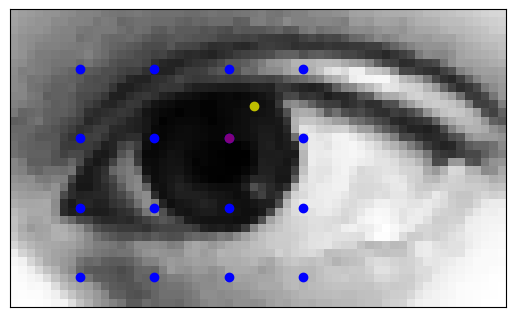

In [ ]:
(img, aux, label) = torch.load("MPIIGaze_preprocessed/train/p14/day06_49_right.pt")
imshape = torch.asarray(img.shape[1::-1])
plt.imshow(torch.flip(img, [1]), cmap="gray");
plt.xticks([]); plt.yticks([]);
# plt.scatter(*((all_labels+.5)*jnp.asarray(img.shape[1::-1])).T, alpha=.02, c="r");
regions = torch.concat([
    torch.cartesian_prod(torch.linspace(-0.3675091, 0.0831264, 4), torch.linspace(-0.31378174, 0.38604215, 4)[:2]),
    torch.cartesian_prod(torch.linspace(-0.3675091, 0.0831264, 4), torch.linspace(-0.31378174, 0.38604215, 4)[2:])
])+.5
plt.scatter(*(regions*imshape).T, c="b");
loc = torch.asarray([torch.arcsin(-label[1]), torch.arctan2(-label[0], -label[2])])+.5
plt.scatter(loc[0]*imshape[0], loc[1]*imshape[1], c="y");
label = torch.abs(loc - regions).sum(axis=1).argmin()
plt.scatter(*(regions[label]*imshape).T, c="purple");

In [ ]:
%load_ext autoreload
%autoreload 2
import os 
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_ops=true"
# os.environ["JAX_DISABLE_MOST_FASTER_PATHS"] = "1"
from data import get_gaze
import fedflax, jax, optax
from fedflax import train
from jax import numpy as jnp
from models import ResNet
from flax import nnx

# Optimizer
opt = lambda model: nnx.Optimizer(
    model,
    optax.adamw(learning_rate=1e-3),
    wrt=nnx.Param
)

# # Identically initialized models, interpretable as collection by nnx 
# keys = nnx.vmap(lambda k: nnx.Rngs(k))(jnp.array([jax.random.key(42)]*4))
# models = nnx.vmap(ResNet)(keys)
# # Ditto for optimizers
# opts = nnx.vmap(opt)(models)

# @nnx.vmap
# @nnx.value_and_grad
# def ell(model, x_batch, z_batch, y_batch):
#     y_pred = model(x_batch, z_batch, train=True)
#     loss = optax.softmax_cross_entropy(y_pred, y_batch).mean()
#     return loss
def ell(model, model_g, x_batch, z_batch, y_batch, train):
    y_pred = model(x_batch, z_batch, train=train)
    loss = optax.softmax_cross_entropy(y_pred, y_batch).mean()
    return loss, (0., 0.)

train_ds = get_gaze("overlap", beta=1.)
# for x,z,y in train_ds:
#     val, grad = ell(models, x, z, y)
#     break

train(ResNet, opt, train_ds, None, ell, local_epochs=10)

In [ ]:
%load_ext autoreload
%autoreload 2
from data import create_imagenet
from matplotlib import pyplot as plt
import jax, optax
from jax import numpy as jnp
from fedflax import train
from flax import nnx
from models import ResNet
n=4

ds_train = create_imagenet(n=n, feature_beta=.1)

def ell(model, model_g, x_batch, y_batch):
    ce = optax.softmax_cross_entropy(model(x_batch), y_batch).mean()
    return ce, (0., ce)

@nnx.jit
@nnx.vmap(in_axes=(0,None,0,0,0))
def train_step(model, model_g, opt, x_batch, y_batch):
    (loss, (prox, ce)), grads = nnx.value_and_grad(ell, has_aux=True)(model, model_g, x_batch, y_batch)
    # grads = jax.tree.map(lambda g: g/2**15, grads)
    opt.update(grads)
    return loss, grads

# Optimizer
opt = lambda model: nnx.Optimizer(
    model,
    optax.adamw(learning_rate=1e-3),
    wrt=nnx.Param
)

# Identically initialized models, interpretable as collection by nnx 
keys = nnx.vmap(lambda k: nnx.Rngs(k))(jnp.array([jax.random.key(42)]*n))
models = nnx.vmap(ResNet)(keys)
# Ditto for optimizers
opts = nnx.vmap(opt)(models)
# Init and save
params, struct = jax.tree.flatten(nnx.to_tree(models))
model_g = nnx.from_tree(jax.tree.unflatten(struct, jax.tree.map(lambda x: jnp.mean(x, axis=0), params)))

for x, y in ds_train:
    loss, grads = train_step(models, model_g, opts, x, y)
    print(loss)
    if jnp.isnan(loss).any():
        print("NaN encountered")
        break

In [ ]:
from jax import numpy as jnp
import torchvision
from matplotlib import pyplot as plt
from scipy.ndimage import map_coordinates
import cv2
import numpy as np

def perspective_shift(image, angle=0, skew_strength=0):
    h, w = image.shape[:2]
    src_pts = np.array([[0, 0], [w, 0], [0, h], [w, h]], dtype=np.float32)
    dx = np.cos(angle) * skew_strength * w
    dy = np.sin(angle) * skew_strength * h
    dst_pts = np.array([
        [0 + dx, 0],
        [w + dx, 0 + dy],
        [0 - dx, h],
        [w - dx, h - dy]
    ], dtype=np.float32)
    transform = cv2.getPerspectiveTransform(src_pts, dst_pts)
    return cv2.warpPerspective(image, transform, (w, h))

image = np.swapaxes(np.asarray(torchvision.io.read_image("/thesis/data/Data/CLS-LOC/train/n01534433/n01534433_47.JPEG")), 0, -1)
distorted_image = perspective_shift(image, angle=jnp.pi/4, skew_strength=1.2)
plt.imshow(distorted_image)